In [2]:
from langchain_ollama import ChatOllama

local_llm = "llama3"
llm = ChatOllama(model=local_llm, temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

In [4]:
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path=".env")

True

# Vector Store

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings

urls = [
    "https://miamiuniversityartmuseum.omeka.net/items/show/20713",
    "https://miamiuniversityartmuseum.omeka.net/items/show/20712",
    "https://miamiuniversityartmuseum.omeka.net/items/show/20711",
]

# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=50, chunk_overlap=10
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
)

# Create retriever
retriever = vectorstore.as_retriever(k=1)

USER_AGENT environment variable not set, consider setting it to identify your requests.
Embedding texts: 100%|██████████| 62/62 [00:00<00:00, 83.19inputs/s]


# Router

In [12]:
import json
from langchain_core.messages import HumanMessage, SystemMessage

# Prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.

The vectorstore contains documents related 17000 objects in the Miami University Art Museum collection, including: paintings, sculptures, and photographs.

Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.

Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question."""


# Retrieval

In [13]:
 # Doc grader instructions
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""


# Generation

In [14]:
rag_prompt = """You are an assistant for question-answering tasks. 

Here is the context to use to answer the question:

{context} 

Think carefully about the above context. 

Now, review the user question:

{question}

Provide an answer to this questions using only the above context. 

Use three sentences maximum and keep the answer concise.

Answer:"""

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Hallucination Grader

In [16]:

hallucination_grader_instructions = """

You are a teacher grading a quiz. 

You will be given FACTS and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""



# Answer Grader

In [17]:
# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) The STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""



# Search

In [18]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# Langgraph

In [19]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated


class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    question: str  # User question
    generation: str  # LLM generation
    web_search: str  # Binary decision to run web search
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]  # List of retrieved documents

In [20]:
from langchain.schema import Document
from langgraph.graph import END


### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "web_search": web_search}


def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents}


### Edges


def route_question(state):
    """
    Route question to web search or RAG

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3)  # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents), generation=generation.content
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question, generation=generation.content
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

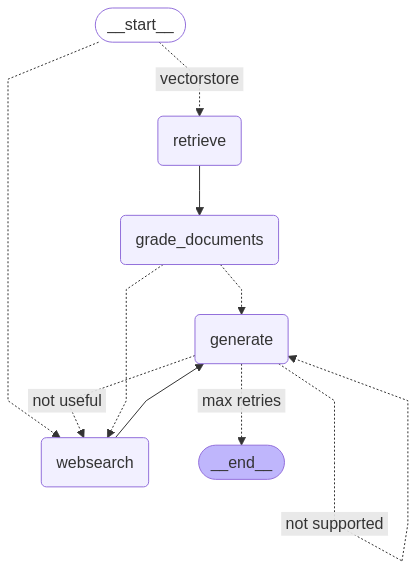

In [21]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
inputs = {"question": "What is the title of the painting of ", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'What is the title of the painting of ', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 28.15inputs/s]

{'question': 'What is the title of the painting of ', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '8e842376-7006-4a5c-a615-ccf79a2e0b92', 'source': 'https://miamiuniversityartmuseum.omeka.net/items/show/20712', 'title': 'Gathering of the Clans · Richard and Carole Cocks Art Museum at Miami University', 'language': 'en-US'}, page_content='Print by the title "Gathering of the Clans" done by color woodcut process on paper in 1952 by American artist Adja Yunkers (1900-1983) as indicated by his signature, title and date in pencil. Printed in'), Document(metadata={'id': '6c75a0c6-a330-47c9-b80a-558e70a8e5e8', 'source': 'https://miamiuniversityartmuseum.omeka.net/items/show/20712', 'title': 'Gathering of the Clans · Richard and Carole Cocks Art Museum at Miami University', 'language': 'en-US'}, page_content='Title\nGathering of the Clans\n\n\nIdentifier\n2024.24\n\n\nSubject\nGraphic Arts-Prints'), Document(metadata={'id': '9f9d92bf-d24f-448c-bc5b-20feeb958bf3', '

---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
{'question': 'What is the title of the painting of ', 'web_search': 'Yes', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '8e842376-7006-4a5c-a615-ccf79a2e0b92', 'source': 'https://miamiuniversityartmuseum.omeka.net/items/show/20712', 'title': 'Gathering of the Clans · Richard and Carole Cocks Art Museum at Miami University', 'language': 'en-US'}, page_content='Print by the title "Gathering of the Clans" done by color woodcut process on paper in 1952 by American artist Adja Yunkers (1900-1983) as indicated by his signature, title and date in pencil. Printed in'), Document(metadata={'id': '9f9d92bf-d24f-448c-bc5b-20feeb958bf3', 'source': 'https://miamiuniversityartmuseum.omeka.net/items/show/20713', 'title': 'Untitled III · 

In [24]:
inputs = {"question": "Type of painting Untitled III ", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'Type of painting Untitled III ', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 13.89inputs/s]

{'question': 'Type of painting Untitled III ', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '9f9d92bf-d24f-448c-bc5b-20feeb958bf3', 'source': 'https://miamiuniversityartmuseum.omeka.net/items/show/20713', 'title': 'Untitled III · Richard and Carole Cocks Art Museum at Miami University', 'language': 'en-US'}, page_content='Print by the title "Untitled III" done by etching and screenprint process on paper in 1978 by American artist Adja Yunkers (1900-1983) as indicated by his signature in pencil. Marked in pencil with the edition number'), Document(metadata={'id': 'cdaa57ee-70a0-40e6-ade1-e2b8c109e48d', 'source': 'https://miamiuniversityartmuseum.omeka.net/items/show/20713', 'title': 'Untitled III · Richard and Carole Cocks Art Museum at Miami University', 'language': 'en-US'}, page_content='Untitled III · Richard and Carole Cocks Art Museum at Miami University\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xa0\nSkip to main content\n\n\nRichard and

---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
{'question': 'Type of painting Untitled III ', 'web_search': 'Yes', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '59b60ab0-35d1-4817-a213-9002a8a28579', 'source': 'https://miamiuniversityartmuseum.omeka.net/items/show/20713', 'title': 'Untitled III · Richard and Carole Cocks Art Museum at Miami University', 'language': 'en-US'}, page_content='Adja Yunkers (American, b. Latvia, 1900-1983), “Untitled III,” Richard and Carole Cocks Art Museum at Miami University, accessed May 10, 2025,')]}
---WEB SEARCH---
{'question': 'Type of painting Untitled III ', 'web_search': 'Yes', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '59b60ab0-35d1-4817-a213-9002a8a28579', 'source': 'https://miamiuniversityart

In [ ]:
inputs = {"question": "Summarise Pink Cone ", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'Summarise Pink Cone ', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 28.87inputs/s]

{'question': 'Summarise Pink Cone ', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '99b70cc8-9bff-456d-9d71-e5b64c2acf9d', 'source': 'https://miamiuniversityartmuseum.omeka.net/items/show/20711', 'title': 'Pink Cone · Richard and Carole Cocks Art Museum at Miami University', 'language': 'en-US'}, page_content='Pink Cone · Richard and Carole Cocks Art Museum at Miami University\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xa0\nSkip to main content'), Document(metadata={'id': '70bfeb28-b1c4-4613-9941-1f8cb3f774e7', 'source': 'https://miamiuniversityartmuseum.omeka.net/items/show/20711', 'title': 'Pink Cone · Richard and Carole Cocks Art Museum at Miami University', 'language': 'en-US'}, page_content='Print by the title "Pink Cone" done by process of hard ground etching printed in pink on gampi paper chine colle in 1995 (edition printed in 2011) by American artist Wayne Thiebaud'), Document(metadata={'id': '62240c13-2bc2-4db0-8001-3f504e2b2a93', 'so

---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
{'question': 'Summarise Pink Cone ', 'web_search': 'No', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '99b70cc8-9bff-456d-9d71-e5b64c2acf9d', 'source': 'https://miamiuniversityartmuseum.omeka.net/items/show/20711', 'title': 'Pink Cone · Richard and Carole Cocks Art Museum at Miami University', 'language': 'en-US'}, page_content='Pink Cone · Richard and Carole Cocks Art Museum at Miami University\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xa0\nSkip to main content'), Document(metadata={'id': '70bfeb28-b1c4-4613-9941-1f8cb3f774e7', 'source': 'https://miamiuniversityartmuseum.omeka.net/items/show/20711', 'title': 'Pink Cone · Richard and Carole Cocks Art Museum at Miami University', 'language': 'en-US'}, page_content='Print by the title "Pink Cone" done by process of har